In [1]:
""" This is  a simple example of using the Generalized Extreme Studentized Deviant (ESD) Test
    I saw a similar topic at:
    https://taher-zadeh.com/outlier-detection-in-nonlinear-least-square-regression/
    And I for a different implement of ESD, check out the excellent pyastronomy Python library:
    https://github.com/sczesla/PyAstronomy/blob/master/src/pyasl/asl/outlier.py
"""

%matplotlib inline
import numpy as np

# first, let's generate some test data (in an exponential curve)
a = 1
b = 1
x = np.arange(0, 5, 0.05)
y_func = lambda x, a, b: a * np.exp(-1.0 * b * x)
y = y_func(x, a, b)

# add some noise to the data
noise = np.random.normal(0, 0.02, len(y))
y = np.absolute(y + noise)

# add some outliers to the data
for u in np.arange(0, len(x), len(x) / 10):
    y[u] = 1.5 * np.random.random()


(0, 5)

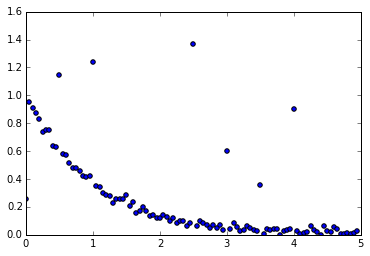

In [2]:
# let's take a quick look at our data
from matplotlib import pyplot as plt
plt.scatter(x, y)
plt.ylim(0, 1.6)
plt.xlim(0, 5)

In [9]:
# Now let's implement the Generalized Extreme Studentized Deviant (ESD) Test
from scipy.stats import norm


def generalized_esd_test(x, max_outlier, alpha=0.05, full_output=False):
    # the maximum number of outliers
    xmasked = np.ma.array(x)
    n = len(xmasked)
    R = []
    Lambda = []
    maxm = []

    for i in range(max_outlier + 1):
        xmean = xmasked.mean()
        xstd  = xmasked.std()

        # Maximum deviation
        max_dev = np.abs((xmasked - xmean) / xstd)
        maxm.append(np.argmax(max_dev))
        R.append(max_dev[maxm[-1]])

        if i >= 1:
            p = 1 - alpha / (2.0 * (n - i + 1))
            crit = norm.ppf(p, n - i - 1.0)
            Lambda.append((n - i) * crit * 0.3 / np.sqrt((n - i - 1 + crit**2) * (n - i + 1)))
            
        # mask that value and proceed
        xmasked[maxm[-1]] = np.ma.masked

    # remove the first entry from R, which is unused
    R.pop(-1)

    # find the number of outliers
    ofound = False
    for j in range(max_outlier - 1, -1, -1):
        if R[j] > Lambda[j]:
            ofound = True
            break

    # Prepare return value
    if ofound:
        if full_output:
            return j + 1, maxm[0: j + 1], R, Lambda, maxm
        else:
            return j + 1, maxm[0: j + 1]
    else:
        if full_output:
            return 0, [], R, Lambda, maxm
        else:
            # No outliers could be detected
            return 0, []


In [7]:
# Now we will fit the data using SciPy's curve_fit

import scipy.optimize as optimization

x0 = np.ones(3)
def fit_func(xx, a, b, c):
    return c + a * np.exp(-1.0 * b * xx)
ls_fit = optimization.curve_fit(fit_func, x, y, x0)
print(ls_fit)


(array([ 0.86153825,  0.760239  ,  0.01865061]), array([[ 0.00649334,  0.00240285, -0.0010637 ],
       [ 0.00240285,  0.03587389,  0.00889789],
       [-0.0010637 ,  0.00889789,  0.00307147]]))


In [10]:
""" Now we take the difference between the fit curve and the actual data points
    And find the bad data points using our ESD function above.
"""

ls_curve = ls_fit[0][2] + ls_fit[0][0] * np.exp(-1.0 * ls_fit[0][1] * np.arange(0, 5, 0.05))

ls_curve_diff = np.abs(ls_curve - y)
num_found, bad_points = generalized_esd_test(ls_curve_diff, 10)
print(num_found, len(bad_points), bad_points)

7 7 [50, 80, 20, 0, 10, 60, 70]


In [11]:
# And now let's re-fit the line, using curve_fit, without the bad data points we just found
xx0 = np.ones(3)
good_xs = [ij for ij in filter(lambda ii: ii not in bad_points, range(len(x)))]
xx = x[good_xs]
yy = y[good_xs]

ls_fit2 = optimization.curve_fit(fit_func, xx, yy, xx0)
ls_curve2 = ls_fit2[0][2] + ls_fit2[0][0] * np.exp(-1.0 * ls_fit2[0][1] * xx)


(0, 5)

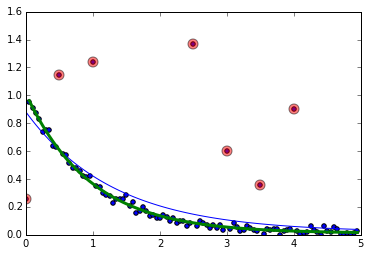

In [12]:
""" Let's plot the data again with:
        the original least squares fit line
        the outlier data points highlighted
        a new least squares fit, without the outliers
"""
# plot all data points
plt.scatter(x, y)
# plot fit to all data points
plt.plot(x, ls_curve, c='red')
# highlight outlier data points
plt.scatter([x[j] for j in bad_points], [y[i] for i in bad_points], s=100, c='red', alpha=0.5)
# plot fit to all non-outlier data points
plt.plot(xx, ls_curve2, c='green', linewidth=3, label='fit without outliers')

# format plot
plt.ylim(0, 1.6)
plt.xlim(0, 5)
